##1. Import library

In [ ]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import re
import nltk # type: ignore
import matplotlib.pyplot as plt # type: ignore
nltk.download('stopwords')

from sklearn.model_selection import train_test_split # type: ignore
from sklearn.feature_extraction.text import TfidfVectorizer # type: ignore
from nltk.corpus import stopwords # type: ignore
from nltk.stem import SnowballStemmer # type: ignore

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##2. Read data

In [ ]:
dataset_path = './data/Twitter_Data.csv'
df = pd.read_csv(dataset_path)
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


##3. Dropna

In [3]:
df = df.dropna()

##4. Normalize

In [4]:
def text_normalize(text):
  text = text.lower()
  text = re.sub(r'^RT[\s]+', '', text)
  text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
  text = re.sub(r'[^\w\s]', '', text)

  stop_words = set(stopwords.words('english'))

  words = text.split()
  words = [word for word in words if word not in stop_words]
  text = ' '.join(words)

  stemmer = SnowballStemmer('english')
  words = text.split()
  words = [stemmer.stem(word) for word in words]
  text = ' '.join(words)

  return text

In [5]:
df['clean_text'] = df['clean_text'].apply(
    lambda text: text_normalize(text)
)

<ipython-input-5-d1f3a8d70eef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['clean_text'].apply(


In [6]:
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df['clean_text']).toarray()

In [7]:
X = np.hstack((np.ones((X.shape[0], 1)), X))
X

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [8]:
df['category'].shape[0]

162969

##5. Encoded label

In [9]:
n_samples = df['category'].shape[0]
n_classes = df['category'].unique().shape[0]
y = df['category'].to_numpy() + 1
y = y.astype(np.uint8)

y_encoded = np.zeros((n_samples, n_classes))
y_encoded[np.arange(n_samples), y] = 1
y_encoded

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

##6. Split train, val, test

In [10]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

##7. Define function

In [11]:
def softmax(z):
    exp_z = np.exp(z)
    return exp_z / exp_z.sum(axis=1)[:, None]

def predict(X, theta):
    y_hat = X @ theta
    return softmax(y_hat)

def compute_loss(y_hat, y):
    N = y.size
    return (-1 / N) * np.sum(y * np.log(y_hat))

def compute_gradient(X, y, y_hat):
    N = y.size
    return X.T @ (y_hat - y) / N

def update_theta(theta, gradient, lr):
    return theta - lr * gradient

def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta)
    acc = (np.argmax(y_hat, axis=1) == np.argmax(y, axis=1)).mean()
    return acc

In [12]:
X_train.shape[1]

2001

##8. Initialize hyperparameter

In [13]:
lr = 0.1
epochs = 200
batchs_size = X_train.shape[0]
n_features = X_train.shape[1]

np.random.seed(random_state)
theta = np.random.uniform(
    size=(n_features, n_classes)
)

##9. Training

In [14]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []
for epoch in range(epochs):
  train_batch_accs = []
  train_batch_losses = []
  val_batch_accs = []
  val_batch_losses = []
  for i in range(0, X_train.shape[0], batchs_size):
    X_i = X_train[i:i + batchs_size]
    y_i = y_train[i:i + batchs_size]

    y_hat = predict(X_i, theta)
    train_loss = compute_loss(y_hat, y_i)
    gradient = compute_gradient(X_i, y_i, y_hat)
    theta = update_theta(theta, gradient, lr)
    train_acc = compute_accuracy(X_i, y_i, theta)

    y_val_hat = predict(X_val, theta)
    val_loss = compute_loss(y_val_hat, y_val)
    val_acc = compute_accuracy(X_val, y_val, theta)

    train_batch_accs.append(train_acc)
    train_batch_losses.append(train_loss)
    val_batch_accs.append(val_acc)
    val_batch_losses.append(val_loss)

  train_acc = sum(train_batch_accs) / len(train_batch_accs)
  train_loss = sum(train_batch_losses) / len(train_batch_losses)
  val_acc = sum(val_batch_accs) / len(val_batch_accs)
  val_loss = sum(val_batch_losses) / len(val_batch_losses)

  train_accs.append(round(train_acc, 4))
  train_losses.append(round(train_loss, 4))
  val_accs.append(round(val_acc, 4))
  val_losses.append(round(val_loss, 4))

  print(f"\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.4f}\tValidation loss: {val_loss:.4f}")


EPOCH 1:	Training loss: 0.3792	Validation loss: 0.3787

EPOCH 2:	Training loss: 0.3788	Validation loss: 0.3783

EPOCH 3:	Training loss: 0.3785	Validation loss: 0.3780

EPOCH 4:	Training loss: 0.3781	Validation loss: 0.3776

EPOCH 5:	Training loss: 0.3778	Validation loss: 0.3773

EPOCH 6:	Training loss: 0.3774	Validation loss: 0.3770

EPOCH 7:	Training loss: 0.3771	Validation loss: 0.3766

EPOCH 8:	Training loss: 0.3768	Validation loss: 0.3763

EPOCH 9:	Training loss: 0.3765	Validation loss: 0.3760

EPOCH 10:	Training loss: 0.3762	Validation loss: 0.3757

EPOCH 11:	Training loss: 0.3759	Validation loss: 0.3754

EPOCH 12:	Training loss: 0.3756	Validation loss: 0.3751

EPOCH 13:	Training loss: 0.3753	Validation loss: 0.3749

EPOCH 14:	Training loss: 0.3750	Validation loss: 0.3746

EPOCH 15:	Training loss: 0.3748	Validation loss: 0.3743

EPOCH 16:	Training loss: 0.3745	Validation loss: 0.3740

EPOCH 17:	Training loss: 0.3742	Validation loss: 0.3738

EPOCH 18:	Training loss: 0.3740	Validat

##10. Visualize loss and accuracy

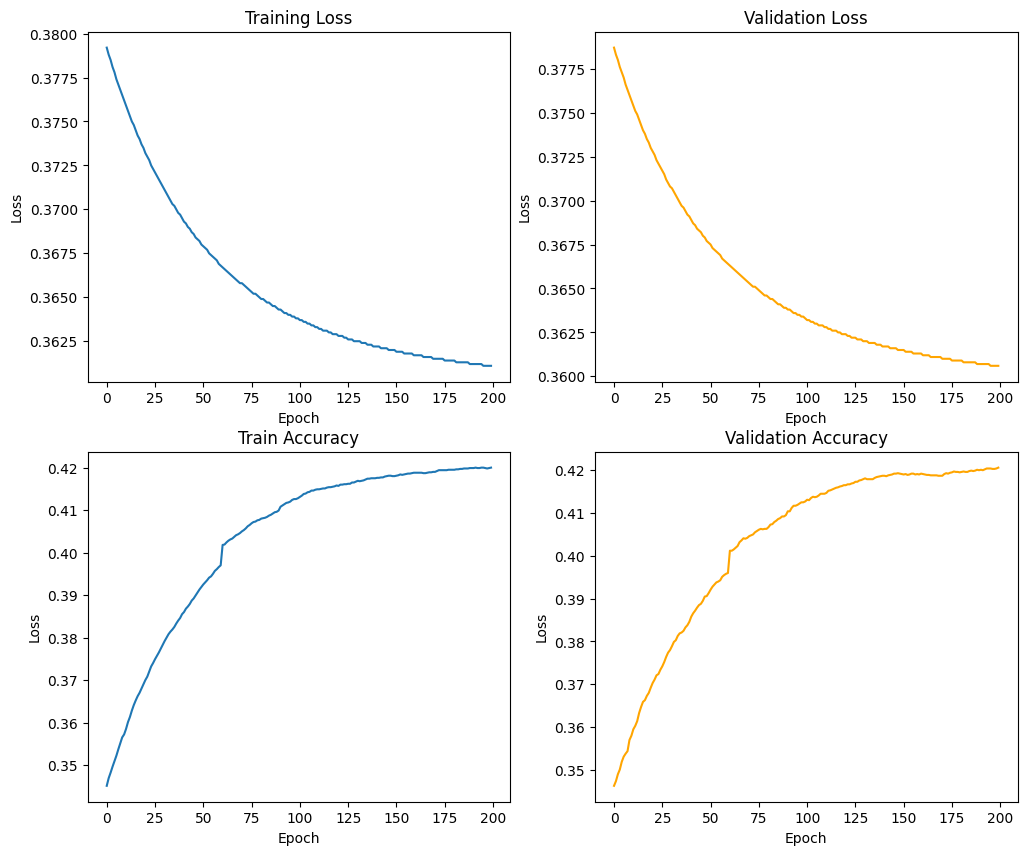

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Loss')
ax[1, 0].set_title('Train Accuracy')

ax[1, 1].plot(val_accs, 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Loss')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

##11. Evaluate

In [16]:
val_set_accs = compute_accuracy(X_val, y_val, theta)
test_set_accs = compute_accuracy(X_test, y_test, theta)
print('Evaluation on validation and test set:')
print(f'Accuracy on validation set: {val_set_accs}')
print(f'Accuracy on test set: {test_set_accs}')

Evaluation on validation and test set:
Accuracy on validation set: 0.42059888323004235
Accuracy on test set: 0.4190341780695834
